In [1]:
from collections import defaultdict
import os
import random

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import partridge as ptg
import seaborn as sns

sns.set(color_codes=True)
%matplotlib inline

In [2]:
START = object()
END = object()


def bus_trips(feed):
    return (feed.stop_times
                .merge(feed.trips.merge(feed.routes[feed.routes.route_type==3]))
                .merge(feed.stops)
                .sort_values('stop_sequence')
                .groupby('trip_id'))


def gen_paths(edges, seen):
    seen = set(seen)
    while True:
        for next_stop_id in set(edges[START]):
            stops = []
            while True:
                next_stop_id = random.choice(edges[next_stop_id])
                if next_stop_id is END: break
                stops.append(next_stop_id)
            pattern = tuple(stops)
            if (
                len(pattern) > 1 and
                len(pattern) == len(set(pattern)) and
                pattern not in seen
            ):
                yield pattern
                seen.add(pattern)


def sampler(feed, n=20, burn_in=500, threshold=0.5):
    trips = bus_trips(feed)
    edges = defaultdict(list)
    seen = set()
    for _trip_id, stop_times in trips:
        pattern = tuple(stop_times.stop_id)
        seen.add(pattern)
        # Weight edges by the number of trips
        edges[START].append(pattern[0])
        edges[pattern[-1]].append(END)
        for a, b in zip(pattern[:-1], pattern[1:]):
            edges[a].append(b)

    patterns = []
    # Allocate a large array of `nan`s to overwrite
    lengths = np.empty(int(1e6), dtype=np.float64)
    lengths.fill(np.nan)
    for i, pattern in enumerate(gen_paths(edges, seen)):
        patterns.append(pattern)
        lengths[i] = len(pattern)
        if (
            burn_in < i and
            # Use standard error of the mean to test convergence
            # http://rlhick.people.wm.edu/stories/bayesian_5.html#
            threshold > lengths[:i].std() / np.sqrt(i)
        ):
            break

    # Select patterns with a "reasonable" number of stops
    lengths = lengths[~np.isnan(lengths)]
    floor = np.percentile(lengths, 40)
    ceil = np.percentile(lengths, 60)
    idxes = set(np.argwhere(np.logical_and(lengths > floor, lengths < ceil))[:,0])
    patterns = [
        pattern for i, pattern in enumerate(patterns)
        if i in idxes
    ]        

    # Find a grouping which forms a DAG... for beauty
    sample_size = min([n, int(0.1 * len(patterns))])
    batches = 0
    while True:
        batches += 1
        sample_patterns = random.sample(patterns, sample_size)
        G = nx.DiGraph()
        for pattern in sample_patterns:
            G.add_edges_from(zip(pattern[:-1], pattern[1:]))
        if nx.is_directed_acyclic_graph(G):
            break

    print(batches, feed.path)
    return sample_patterns, lengths

In [3]:
paths = [
    'data/TriMet-2018-02-06.zip',
    'data/SFMTA-2017-10-26.zip',
    'data/LA-Metro-Bus-2018-02-20.zip',
    'data/MBTA-2018-02-28.zip',
    'data/Greater-Sydney-2017-06-13.zip',
]

results = {}
for path in paths:
    feed = ptg.get_representative_feed(path)
    stops = {s.stop_id: dict(s) for _, s in feed.stops.iterrows()}
    samples, lengths = sampler(feed, n=1, burn_in=500, threshold=0.8)
    results[path] = dict(feed=feed, samples=samples, lengths=lengths, stops=stops)

1 data/TriMet-2018-02-06.zip
1 data/SFMTA-2017-10-26.zip
1 data/LA-Metro-Bus-2018-02-20.zip
1 data/MBTA-2018-02-28.zip
1 data/Greater-Sydney-2017-06-13.zip


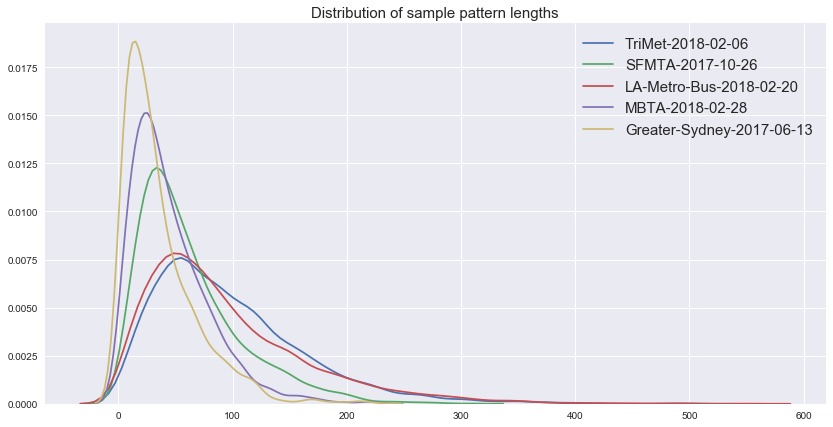

In [4]:
fig, ax = plt.subplots(figsize=(14, 7));

for path, result in results.items():
    label, _ = os.path.splitext(os.path.basename(path))
    _ = sns.kdeplot(result['lengths'], ax=ax, label=label)

plt.title('Distribution of sample pattern lengths', size=15);
plt.legend(prop=dict(size=15));

In [5]:
result = results[paths[1]]
pattern = result['samples'][0]
for stop_id in pattern:
    print(result['stops'][stop_id]['stop_name'])

INDUSTRIAL ST & BAY SHORE BLVD
INDUSTRIAL ST & ELMIRA ST
INDUSTRIAL ST & PALOU AVE
PALOU AVE & RANKIN ST
PALOU AVE & QUINT ST
PALOU AVE & PHELPS ST
PALOU AVE & NEWHALL ST
PALOU AVE & PHELPS ST
PALOU AVE & QUINT ST
SILVER AVE & REVERE AVE
SILVER AVE & TOPEKA AVE
SILVER AVE & AUGUSTA ST
SILVER AVE & CHARTER OAK AVE
SILVER AVE & SAN BRUNO AVE
SILVER AVE & MERRILL ST
SILVER AVE & BOYLSTON ST
SILVER AVE & DARTMOUTH ST
SILVER AVE & PRINCETON ST
SILVER AVE & CAMBRIDGE ST
SILVER AVE & GAMBIER ST
SILVER AVE & CONGDON ST
SILVER AVE & LISBON ST
SILVER AVE & MISSION ST
SILVER AVE & ALEMANY BLVD
ROUSSEAU ST & CAYUGA AVE
STILL ST & LYELL ST
BOSWORTH ST & DIAMOND ST
DIAMOND ST & CHENERY ST
CHENERY ST & NATICK ST
CHENERY ST & ROANOKE ST
CHENERY ST & MATEO ST
CHENERY ST & MIGUEL ST
MIGUEL ST & LAIDLEY ST
BEMIS ST & ADDISON ST
46 ADDISON ST
164 ADDISON  ST
ADDISON  ST & DIGBY ST
ADDISON  ST & FARNUM ST
DIAMOND HEIGHTS BLVD & ADDISON ST
DIAMOND ST & DIAMOND HEIGHTS BLVD
DIAMOND ST & 29TH ST
DIAMOND ST & 